In [1]:
# MO444-A 2s/2017 - First assignment
#
#         Group 05
#
# - Anderson Rossanez (124136)
# - Bruno Branta Lopes (31470)
#

# Plotting inline instead of opening an outer window.
%matplotlib inline

# Imports
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from math import sqrt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold

# Defines
years = range(1922, 2011)
random_state = np.random.RandomState(1)

# Functions
def load_data(filename):
    raw_data = open(filename, 'rt')
    data = np.loadtxt(raw_data, delimiter=",")
    return data

def split_Y_X(dataset):
    Y = dataset[:,0]
    X = dataset[:,1:]
    return Y, X

def get_errors_by_year(model, data_Y, data_X):
    errors = []
    for y in years:
        filt = data_Y == y
        if not sum(filt):
            errors.append(0)
            continue
        errors.append(mean_squared_error(data_Y[filt], model.predict(data_X[filt])))
    return errors

In [2]:
# load training data
data = load_data('year-prediction-msd-train.txt')

print('Training data size: {}'.format(len(data)))

Training data size: 463715


In [3]:
# Take a look at the data (5 first instances):
# - first column (index 0) is the song release year
# - remaining columns are the the features (indexes 1 - 90)
data_frame = pd.DataFrame(data)
data_frame.head(5)

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2004.0,46.50128,-18.37096,58.89824,27.28181,1.93097,-2.43167,18.64843,-5.62769,-1.47711,...,43.94716,-64.21148,13.04284,156.03785,-2.42670,51.71977,-43.56703,10.63735,24.08962,-21.41886
1,2005.0,41.46015,-52.30140,-4.59825,-19.28084,-11.85844,-19.54192,1.30306,-1.83185,5.98469,...,-13.48435,-154.65715,35.22429,89.53649,-3.13145,-128.28120,89.97277,-15.88139,-75.21074,-0.51139
2,2009.0,42.18667,-85.65863,-7.91506,-11.84193,-12.61959,-21.66749,4.97883,-11.86750,9.87342,...,42.08584,-181.77349,43.00181,87.94977,-13.70362,136.49979,140.32633,11.51422,382.79589,29.98269
3,1987.0,46.90244,19.86314,10.92119,4.87136,-41.17499,-19.84156,2.93308,-5.98711,3.05997,...,-2.76407,-20.31782,-75.24506,125.81801,-15.50828,-63.31002,-142.21937,-12.36699,32.45911,-17.14909
4,2009.0,46.64388,-81.99503,41.62851,3.65855,-9.38201,-13.51749,7.48781,-7.03302,7.06982,...,12.29244,-143.25348,91.15842,-227.85481,7.75916,-41.32376,-225.66526,-4.05081,455.39458,41.65310


In [4]:
# load test data
test_data = load_data('year-prediction-msd-test.txt')

print('Test data size: {}'.format(len(test_data)))

Test data size: 36285


In [5]:
# split train data into training/validation (80/20)
train_data, validation_data = train_test_split(data, test_size=0.2)

print('Train data size: {}'.format(len(train_data)))
print('Validation data size: {}'.format(len(validation_data)))

# prepare for 5-fold execution
k5_fold = KFold(n_splits=5, shuffle=True, random_state=random_state)
data_Y, data_X = split_Y_X(data)

def run_kfold(method):
    train_msq_err, train_r2_score = [], []
    validation_msq_err, validation_r2_score = [], []
    start_time = datetime.now()
    k = 0
    print('k', end=' ')
    model = None
    for train_index, validation_index in k5_fold.split(data):
        k += 1
        print(k, end=' ')
        
        train_data_X, train_data_Y = data_X[train_index], data_Y[train_index]
        validation_data_X, validation_data_Y = data_X[validation_index], data_Y[validation_index]
        model = method(train_data_X, train_data_Y)
        
        predicted_train_data_Y = model.predict(train_data_X)
        train_msq_err.append(sqrt(mean_squared_error(train_data_Y, predicted_train_data_Y)))
        train_r2_score.append(r2_score(train_data_Y, predicted_train_data_Y))
        
        predicted_validation_data_Y = model.predict(validation_data_X)
        validation_msq_err.append(sqrt(mean_squared_error(validation_data_Y, predicted_validation_data_Y)))
        validation_r2_score.append(r2_score(validation_data_Y, predicted_validation_data_Y))
    print('time elapsed: {}\n'.format(datetime.now() - start_time))
    print('                       RMSE         R2 Score')
    print('Training:    %5.2f sd %5.2f   %5.2f sd %5.2f' % (
                np.mean(train_msq_err), np.std(train_msq_err), np.mean(train_r2_score), np.std(train_r2_score)))
    print('Validation:  %5.2f sd %5.2f   %5.2f sd %5.2f' % (
                np.mean(validation_msq_err), np.std(validation_msq_err), np.mean(validation_msq_err), np.std(validation_msq_err)))
    return model

Train data size: 370972
Validation data size: 92743


In [6]:
# Split label (years) and features
train_data_Y, train_data_X = split_Y_X(train_data)
validation_data_Y, validation_data_X = split_Y_X(validation_data)
test_data_Y, test_data_X = split_Y_X(test_data)

In [7]:
# Create a baseline linear regression model and train it
lr_base_model = run_kfold(lambda X, Y: LinearRegression(copy_X=True).fit(X, Y))

k 1 2 3 4 5 time elapsed: 0:00:40.850818

                       RMSE         R2 Score
Training:     9.55 sd  0.00    0.24 sd  0.00
Validation:   9.56 sd  0.02    9.56 sd  0.02


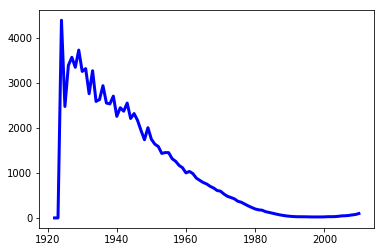

In [8]:
# plotting the errors
errors = get_errors_by_year(lr_base_model, validation_data_Y, validation_data_X)
plt.plot(years, errors, color='blue', linewidth=3)
plt.show()

In [9]:
# LR-based alternative #1: LR with Stochastic Gradient Descent
lr_sgd_model = SGDRegressor(loss='squared_loss', penalty=None)

# normalize the data before fitting
lr_sgd_scaler = preprocessing.StandardScaler()

lr_sgd_model.fit(lr_sgd_scaler.fit_transform(train_data_X), train_data_Y )

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty=None, power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)

In [10]:
# Check the model errors
predicted_train_data_Y = lr_sgd_model.predict(lr_sgd_scaler.transform(train_data_X))
mean_sq_error_training = mean_squared_error(train_data_Y, predicted_train_data_Y)
print('Training root mean squared error: {}'.format(sqrt(mean_sq_error_training)))
print('Training score: {}'.format(r2_score(train_data_Y, predicted_train_data_Y)))

predicted_validation_data_Y = lr_sgd_model.predict(lr_sgd_scaler.transform(validation_data_X))
mean_sq_error_validation = mean_squared_error(validation_data_Y, predicted_validation_data_Y)
print('Validation root mean squared error: {}'.format(sqrt(mean_sq_error_validation)))
print('Validation score: {}'.format(r2_score(validation_data_Y, predicted_validation_data_Y)))

Training root mean squared error: 9.60720799468
Training score: 0.228397183712
Validation root mean squared error: 9.61220403275
Validation score: 0.229498769549


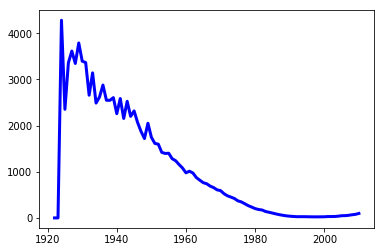

In [11]:
# Plotting the errors:
errors = get_errors_by_year(lr_sgd_model, validation_data_Y, lr_sgd_scaler.transform(validation_data_X))
plt.plot(years, errors, color='blue', linewidth=3)
plt.show()

In [12]:
# LR-based alternative #2: Mini-batch Gradient Descent
lr_mbgd_model = SGDRegressor(loss='squared_loss', penalty=None)

# normalize the data before fitting
lr_mbgd_scaler = preprocessing.StandardScaler()
trans_train_data_X = lr_mbgd_scaler.fit_transform(train_data_X)

# feed the data partially
n_chunks = 10
chunk_size = len(train_data_Y) / n_chunks
for i in range(0, n_chunks):
    range_start = i * chunk_size
    range_end = (i + 1) * chunk_size
    lr_mbgd_model.partial_fit(trans_train_data_X[range_start:range_end], train_data_Y[range_start:range_end])    

In [13]:
# Check the model errors
predicted_train_data_Y = lr_mbgd_model.predict(lr_mbgd_scaler.transform(train_data_X))
mean_sq_error_training = mean_squared_error(train_data_Y, predicted_train_data_Y)
print('Training root mean squared error: {}'.format(sqrt(mean_sq_error_training)))
print('Training score: {}'.format(r2_score(train_data_Y, predicted_train_data_Y)))

predicted_validation_data_Y = lr_mbgd_model.predict(lr_mbgd_scaler.transform(validation_data_X))
mean_sq_error_validation = mean_squared_error(validation_data_Y, predicted_validation_data_Y)
print('Validation root mean squared error: {}'.format(sqrt(mean_sq_error_validation)))
print('Validation score: {}'.format(r2_score(validation_data_Y, predicted_validation_data_Y)))

Training root mean squared error: 9.6299217589
Training score: 0.224744359227
Validation root mean squared error: 9.646761772
Validation score: 0.223948607536


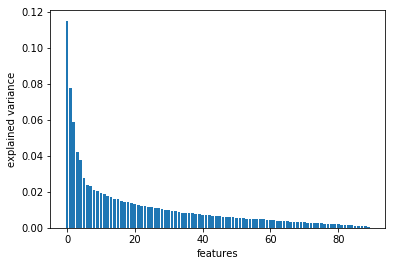

[ 0.11514512  0.07783896  0.05907159  0.04198822  0.03765427  0.0276047
  0.0236403   0.02313859  0.02091323  0.02022156  0.01915767  0.01855908
  0.01787976  0.01687675  0.01612486  0.01592125  0.01517471  0.01422743
  0.0140944   0.01352132  0.01313667  0.01258179  0.01235729  0.01186756
  0.01157583  0.01142901  0.01111722  0.01093721  0.01043059  0.01009683
  0.00982123  0.00942049  0.00925506  0.00897263  0.00842424  0.00819823
  0.00805296  0.00798761  0.00757971  0.00747568  0.00731917  0.00718031
  0.00699861  0.00681519  0.00659791  0.00634701  0.00627518  0.00616818
  0.00596187  0.00584202  0.00569111  0.00553009  0.00535476  0.00516451
  0.00502914  0.00499926  0.00486445  0.00472119  0.00461819  0.00438247
  0.00424512  0.00411248  0.0039757   0.00394611  0.00372011  0.00364733
  0.00349665  0.0033797   0.0032493   0.0031563   0.003039    0.0029207
  0.00275946  0.0027431   0.00261272  0.00247707  0.00228219  0.0021571
  0.0020865   0.00204538  0.00189293  0.00175566  0.00

In [14]:
# LR-based alternative #3: Feature reduction

# Principal component analysis (PCA)
pca_scaler = preprocessing.StandardScaler()
pca = PCA(n_components=90).fit(pca_scaler.fit_transform(train_data_X))
plt.bar(range(0, 90), pca.explained_variance_ratio_)
plt.xlabel('features')
plt.ylabel('explained variance')
plt.show()
print(pca.explained_variance_ratio_)

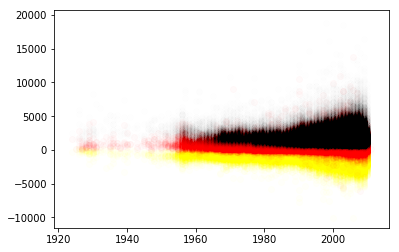

In [15]:
# First three PCA components plotted
transformed_data = pca.transform(validation_data_X)
plt.scatter(validation_data_Y, transformed_data[:,2], color='yellow', alpha=0.02)
plt.scatter(validation_data_Y, transformed_data[:,1], color='red', alpha=0.02)
plt.scatter(validation_data_Y, transformed_data[:,0], color='black', alpha=0.005)
plt.show()

In [17]:
for n_components in range(0, 91, 10):
    n_components = n_components or 1
    transformed_train_data_X = pca.transform(train_data_X)[:,range(0, n_components)]

    lr_pca_model = LinearRegression(copy_X=True)
    lr_pca_model.fit(transformed_train_data_X, train_data_Y)

    mean_sq_error_training = mean_squared_error(train_data_Y, lr_pca_model.predict(transformed_train_data_X))
    
    transformed_validation_data_X = pca.transform(validation_data_X)[:,range(0, n_components)]
    mean_sq_error_validation = mean_squared_error(validation_data_Y, lr_pca_model.predict(transformed_validation_data_X))

    print('%2d PCA components used: %5.2f %5.2f' % (n_components, sqrt(mean_sq_error_training), sqrt(mean_sq_error_validation)))


 1 PCA components used: 10.93 10.95
10 PCA components used: 10.66 10.68
20 PCA components used: 10.57 10.59
30 PCA components used: 10.44 10.47
40 PCA components used: 10.40 10.42
50 PCA components used: 10.29 10.32
60 PCA components used: 10.23 10.26
70 PCA components used: 10.19 10.22
80 PCA components used:  9.97 10.00
90 PCA components used:  9.55  9.56


In [ ]:
# performs ridge regression for 1 to 4 degrees
n_components = 7
for degree in range(1, 5):
    transformed_train_data_X = pca.transform(train_data_X)[:,range(0, n_components)]
    model = make_pipeline(PolynomialFeatures(degree), Ridge())
    # model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(transformed_train_data_X, train_data_Y)
    
    mean_sq_error_training = mean_squared_error(train_data_Y, model.predict(transformed_train_data_X))
    
    transformed_validation_data_X = pca.transform(validation_data_X)[:,range(0, n_components)]
    mean_sq_error_validation = mean_squared_error(validation_data_Y, model.predict(transformed_validation_data_X))

    print('%d degrees: %5.2f %5.2f' % (degree, sqrt(mean_sq_error_training), sqrt(mean_sq_error_validation)))

1 degrees: 10.68 10.70
2 degrees: 10.60 10.63
3 degrees: 10.54 10.58
